<h1>Рынок заведений общественного питания в Москве</h1>

Открытие нового кафе в Москве. Необходимо подготовить исследование рынка для инвесторов о заведениях общественного питания в Москве

## Подготовка данных

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import requests
import json
import numpy

In [2]:
data = pd.read_csv('/datasets/rest_data.csv')
pd.set_option("max_colwidth", 120)
data

,id,object_name,chain,object_type,address,number
0,151635,СМЕТАНА,нет,кафе,"город Москва, улица Егора Абакумова, дом 9",48
1,77874,Родник,нет,кафе,"город Москва, улица Талалихина, дом 2/1, корпус 1",35
2,24309,Кафе «Академия»,нет,кафе,"город Москва, Абельмановская улица, дом 6",95
3,21894,ПИЦЦЕТОРИЯ,да,кафе,"город Москва, Абрамцевская улица, дом 1",40
4,119365,Кафе «Вишневая метель»,нет,кафе,"город Москва, Абрамцевская улица, дом 9, корпус 1",50
...,...,...,...,...,...,...
15361,208537,Шоколадница,да,кафе,"город Москва, 3-й Крутицкий переулок, дом 18",50
15362,209264,Шоколадница,да,кафе,"город Москва, улица Земляной Вал, дом 33",10
15363,209186,Шоколадница,да,кафе,"город Москва, улица Земляной Вал, дом 33",20
15364,221900,Шоколадница,да,кафе,"город Москва, поселение Московский, Киевское шоссе, 22-й километр, домовладение 4, строение 1",36


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15366 entries, 0 to 15365
Data columns (total 6 columns):
id             15366 non-null int64
object_name    15366 non-null object
chain          15366 non-null object
object_type    15366 non-null object
address        15366 non-null object
number         15366 non-null int64
dtypes: int64(2), object(4)
memory usage: 720.4+ KB


Типы данных правильные. Можно привести столбец chain к типу bool, однако в данном проекте не так много строк, чтобы это на что-то повлияло.

In [4]:
data.isna().sum()

id             0
object_name    0
chain          0
object_type    0
address        0
number         0
dtype: int64

In [5]:
data.describe()

,id,number
count,15366.000000,15366.000000
mean,119720.066901,59.547182
std,73036.130732,74.736833
min,838.000000,0.000000
25%,28524.000000,12.000000
50%,144974.500000,40.000000
75%,184262.250000,80.000000
max,223439.000000,1700.000000


Есть нулевые значения в столбце number, которые надо проверить. Также есть выбросы, буду проверять их в процессе проекта.

In [6]:
data.query('number == 0')['object_type'].unique()

array(['закусочная', 'предприятие быстрого обслуживания', 'столовая',
       'кафетерий', 'кафе', 'магазин (отдел кулинарии)', 'буфет', 'бар',
       'ресторан'], dtype=object)

Проверка заведений без посадочных мест: магазины и предприятие быстрого обслуживания не имеют посадочные места, кафе - это кафе-бистро, рестораны - это рестораны быстрого питания, бары - мини-бары только с барной стойкой или открыты в клубах, кафетерий - кофе с собой, буфеты - как предприятия быстрого обслуживания. Столовые - при школе (не знаю, почему без посадочных мест, возможно также, как буфет - только с прилавком). В целом, отсутствие посадочных мест у заведений объяснимо, делать с ними ничего не буду.

In [7]:
# проверка на дубликаты
data['object_name'] = data['object_name'].str.lower()
data.duplicated().sum()

0

In [8]:
data[data[['object_name', 'chain', 'object_type', 'address', 'number']].duplicated()].sort_values(by='object_name')

,id,object_name,chain,object_type,address,number
13858,209723,laltro bosco,нет,ресторан,"город Москва, улица Петровка, дом 10",145
5059,20021,lift,нет,кафе,"город Москва, Багратионовский проезд, дом 7, корпус 1",20
5069,20025,lift,нет,кафе,"город Москва, Багратионовский проезд, дом 7, корпус 3",10
14844,219518,sushi-make,нет,предприятие быстрого обслуживания,"город Москва, Ярцевская улица, дом 19",0
5762,134324,алекс,нет,кафе,"город Москва, Тихорецкий бульвар, владение 1, строение 2",45
...,...,...,...,...,...,...
11242,174865,шаурма,нет,предприятие быстрого обслуживания,"город Москва, Свободный проспект, дом 33А",1
12764,197518,шаурма,нет,закусочная,"город Москва, проспект Мира, дом 102, корпус 1",0
9933,170964,шаурма,нет,предприятие быстрого обслуживания,"город Москва, улица Народного Ополчения, дом 22, корпус 1",0
14119,222452,шаурма,нет,предприятие быстрого обслуживания,"город Москва, улица Сущёвский Вал, дом 5, строение 5",1


85 дубликатов, это 0,5%, следовательно, можно удалить строки

In [9]:
# удаление дубликатов
data.drop(data[data[['object_name', 'chain', 'object_type', 'address', 'number']].duplicated()].index, inplace=True)
data[data[['object_name', 'chain', 'object_type', 'address', 'number']].duplicated()]

,id,object_name,chain,object_type,address,number


## Анализ данных

### Исследование соотношения видов объектов общественного питания по количеству

In [10]:
# стиль для всех последующих графиков
sns.set_palette('deep')

In [11]:
data_type = data.groupby('object_type').agg(count=('id','count')).sort_values(by='count', ascending=False)
data_type

,count
object_type,
кафе,6071
столовая,2584
ресторан,2282
предприятие быстрого обслуживания,1897
бар,855
буфет,576
кафетерий,395
закусочная,348
магазин (отдел кулинарии),273


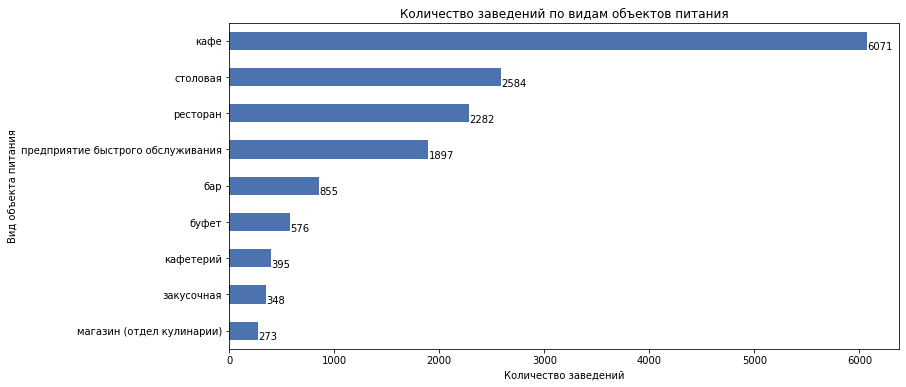

In [12]:
ax = data_type.plot(kind='barh', legend=None, figsize=(12,6))
ax.invert_yaxis()
ax.set_title('Количество заведений по видам объектов питания') 
ax.set_ylabel('Вид объекта питания')
ax.set_xlabel("Количество заведений")
for i, v in enumerate(data_type['count']):
    ax.text(v + 5, i + .25, str(v))

Text(0.5, 1.0, 'Соотношение видов объектов питания по количеству заведений')

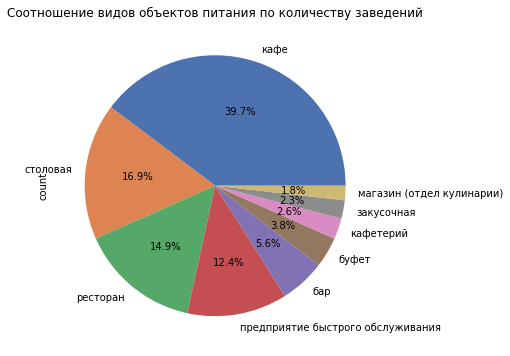

In [13]:
ax = data_type.plot(kind='pie', y='count', legend=None, figsize=(12,6), autopct='%1.1f%%')
ax.set_title('Соотношение видов объектов питания по количеству заведений') 

Больше всего заведений вида "кафе" - 6071 шт - и они составляют 39,7% от общего числа заведений.
Топ-3 объектов по количеству заведений: кафе, столовые, рестораны

### Исследование соотношения сетевых и несетевых заведений по количеству

In [14]:
data_chain = data.copy()
data_chain = data_chain.replace({'chain':{"нет":"не сетевые", "да":"сетевые"}})
data_chain = data_chain.groupby('chain').agg(count=('id','count')).sort_values(by='count', ascending=False).reset_index()

data_chain

,chain,count
0,не сетевые,12317
1,сетевые,2964


Text(0, 0.5, 'Количество заведений')

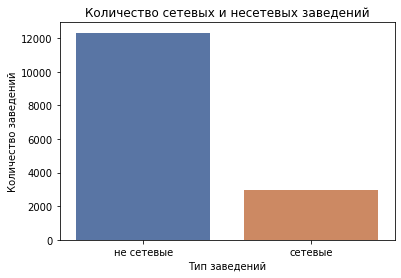

In [15]:
ax = sns.barplot(x='chain', y='count', data=data_chain)
ax.set_title('Количество сетевых и несетевых заведений')
ax.set_xlabel('Тип заведений')
ax.set_ylabel("Количество заведений")

Количество несетевых заведений в 4 раза больше, чем сетевых.

### Виды сетевых объектов общественного питания

In [16]:
data_type_chain = data.query('chain == "да"')\
    .groupby('object_type').agg(count=('id','count')).sort_values(by='count', ascending=False)
data_type_chain

,count
object_type,
кафе,1396
предприятие быстрого обслуживания,788
ресторан,543
магазин (отдел кулинарии),78
закусочная,56
кафетерий,52
бар,37
буфет,11
столовая,3


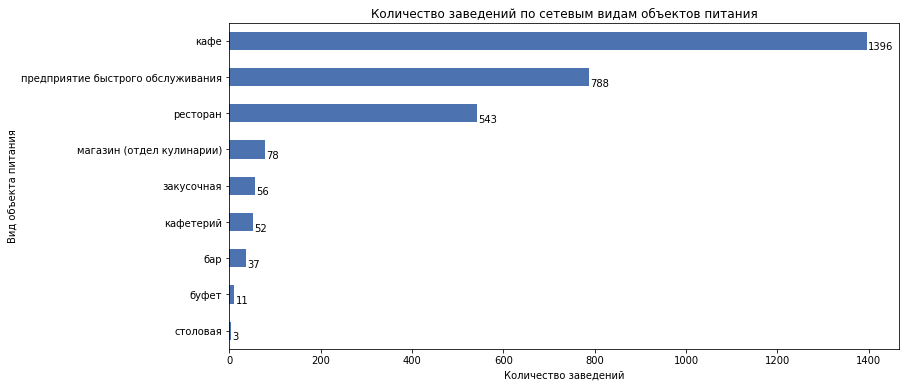

In [17]:
ax = data_type_chain.plot(kind='barh', legend=None, figsize=(12,6))
ax.invert_yaxis()
ax.set_title('Количество заведений по сетевым видам объектов питания') 
ax.set_ylabel('Вид объекта питания')
ax.set_xlabel("Количество заведений")
for i, v in enumerate(data_type_chain['count']):
    ax.text(v + 3, i + .25, str(v))

Text(0.5, 1.0, 'Соотношение сетевых видов объектов питания по количеству заведений')

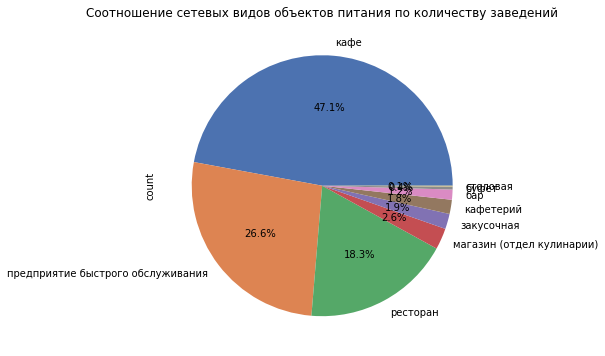

In [18]:
ax = data_type_chain.plot(kind='pie', y='count', legend=None, figsize=(12,6), autopct='%1.1f%%')
ax.set_title('Соотношение сетевых видов объектов питания по количеству заведений') 

Больше всего заведений вида "кафе" - 1396 шт - и они составляют 47,1% от общего числа заведений.
Топ-3 объектов по количеству заведений: кафе, предприятия быстрого обслуживания, рестораны; в сумме дают 92% об общего числа заведений.

### Распределение заведений по виду сетевых объектов питания и количеству посадочных мест

In [19]:
data_chain_yes = data.query('chain == "да"')
data_chain_yes

,id,object_name,chain,object_type,address,number
3,21894,пиццетория,да,кафе,"город Москва, Абрамцевская улица, дом 1",40
6,148815,брусника,да,кафе,"город Москва, переулок Сивцев Вражек, дом 6/2",10
13,22579,алло пицца,да,кафе,"город Москва, улица Авиаторов, дом 14",32
16,144107,суши wok,да,предприятие быстрого обслуживания,"город Москва, Азовская улица, дом 3",7
18,58565,тануки,да,ресторан,"город Москва, Большая Академическая улица, дом 65",160
...,...,...,...,...,...,...
15361,208537,шоколадница,да,кафе,"город Москва, 3-й Крутицкий переулок, дом 18",50
15362,209264,шоколадница,да,кафе,"город Москва, улица Земляной Вал, дом 33",10
15363,209186,шоколадница,да,кафе,"город Москва, улица Земляной Вал, дом 33",20
15364,221900,шоколадница,да,кафе,"город Москва, поселение Московский, Киевское шоссе, 22-й километр, домовладение 4, строение 1",36


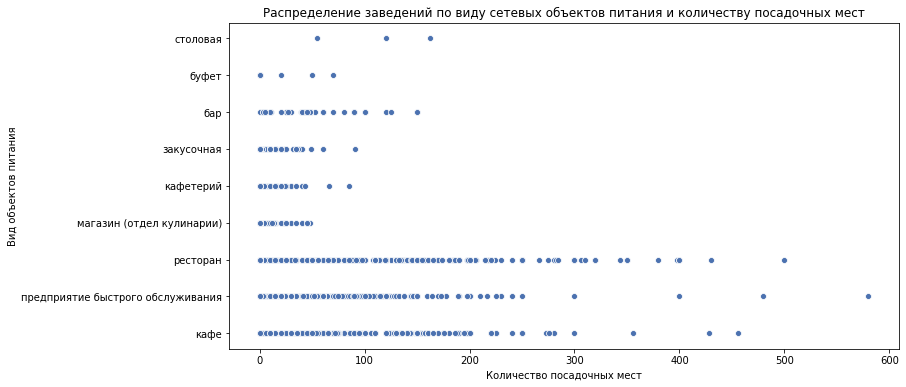

In [20]:
ax = sns.scatterplot(
    data=data_chain_yes, 
    y="object_type", 
    x="number"
)
ax.set_title('Распределение заведений по виду сетевых объектов питания и количеству посадочных мест') 
ax.set_ylabel('Вид объектов питания')
ax.set_xlabel("Количество посадочных мест")
ax.figure.set_figwidth(12)
ax.figure.set_figheight(6)

Для сетевых объектов питания характерно большое количество заведений с небольшим количеством посадочных мест.

### Среднее количество посадочных мест для каждого вида объекта питания

In [21]:
data_number_all = data.groupby('object_type').agg(mean_number=('number','mean')).sort_values(by='mean_number', ascending=False)
data_number_all['mean_number'] = data_number_all['mean_number'].astype("int")
data_number_all

,mean_number
object_type,
столовая,130
ресторан,96
буфет,51
бар,43
кафе,39
предприятие быстрого обслуживания,20
кафетерий,9
закусочная,7
магазин (отдел кулинарии),5


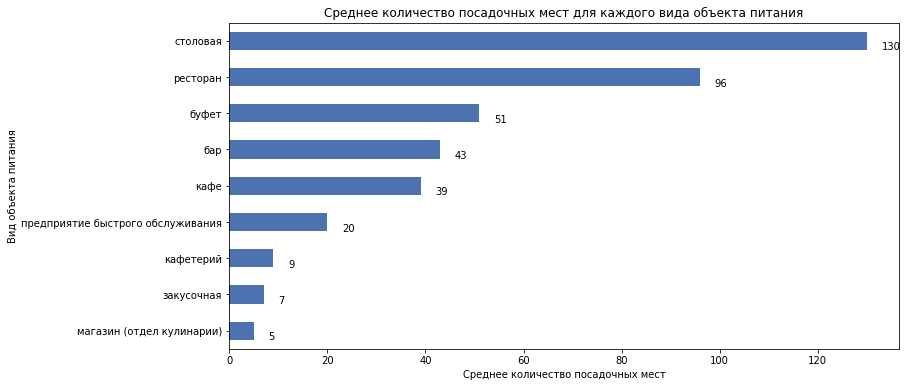

In [22]:
ax = data_number_all.plot(kind='barh', figsize=(12,6), legend=None)
ax.invert_yaxis()
ax.set_title('Среднее количество посадочных мест для каждого вида объекта питания') 
ax.set_ylabel('Вид объекта питания')
ax.set_xlabel("Среднее количество посадочных мест")
for i, v in enumerate(data_number_all['mean_number']):
    ax.text(v + 3, i + .25, str(v))

Топ-3 по количеству посадочных мест: столовые, рестораны, буфеты.

### Добавление информации об об улице

In [23]:
# заменяю в адресах букву ё на е для корректной работы регулярных выражений
data['address'] = data['address'].str.replace('ё', 'е', regex = True)

In [24]:
# функция берет строку из столбца address и записывает в столбец street информацию об улице(переулка, проезда и т.п.)
# если информации об улице нет, то заполняет строкой Empty (в случае, когда указан только город, или деревня)

reg_street = '\,\s*(.*(улица|переулок|шоссе|бульвар|проезд|проспект|набережная|площадь|аллея|линия)[0-9А-я-\s]*)\,'

def regexp(string):
    if (re.search(reg_street, string) == None):
        string_new = 'Empty'
    else: string_new = re.search(reg_street, string).group(1)
    return string_new

data['street'] = data['address'].apply(regexp)

data

,id,object_name,chain,object_type,address,number,street
0,151635,сметана,нет,кафе,"город Москва, улица Егора Абакумова, дом 9",48,улица Егора Абакумова
1,77874,родник,нет,кафе,"город Москва, улица Талалихина, дом 2/1, корпус 1",35,улица Талалихина
2,24309,кафе «академия»,нет,кафе,"город Москва, Абельмановская улица, дом 6",95,Абельмановская улица
3,21894,пиццетория,да,кафе,"город Москва, Абрамцевская улица, дом 1",40,Абрамцевская улица
4,119365,кафе «вишневая метель»,нет,кафе,"город Москва, Абрамцевская улица, дом 9, корпус 1",50,Абрамцевская улица
...,...,...,...,...,...,...,...
15361,208537,шоколадница,да,кафе,"город Москва, 3-й Крутицкий переулок, дом 18",50,3-й Крутицкий переулок
15362,209264,шоколадница,да,кафе,"город Москва, улица Земляной Вал, дом 33",10,улица Земляной Вал
15363,209186,шоколадница,да,кафе,"город Москва, улица Земляной Вал, дом 33",20,улица Земляной Вал
15364,221900,шоколадница,да,кафе,"город Москва, поселение Московский, Киевское шоссе, 22-й километр, домовладение 4, строение 1",36,"поселение Московский, Киевское шоссе"


In [25]:
data.query('street == "Empty"').shape[0]

483

После добавления улиц пустыми получились 483 строки, это 3%, оставлю как погрешность (не уверена, что стоит на данный момент тратить на них время)

### Топ-10 улиц по количеству объектов общественного питания, районы их расположения.

In [26]:
data_street = data.query('street != "Empty"').groupby('street').agg(count_object=('id','count')).sort_values(by='count_object', ascending=False).reset_index().head(10)
data_street

,street,count_object
0,проспект Мира,203
1,Профсоюзная улица,181
2,Ленинградский проспект,170
3,Пресненская набережная,167
4,Варшавское шоссе,161
5,Ленинский проспект,147
6,проспект Вернадского,128
7,Кутузовский проспект,114
8,Каширское шоссе,111
9,Кировоградская улица,108


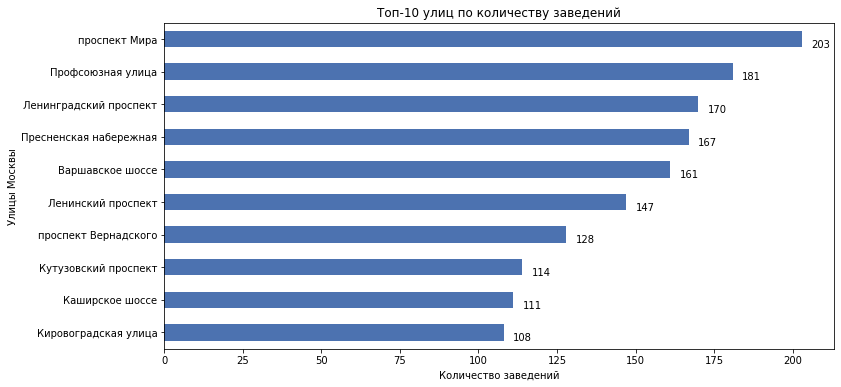

In [27]:
ax = data_street.plot(kind='barh', x='street', figsize=(12,6), legend=None)
ax.invert_yaxis()
ax.set_title('Топ-10 улиц по количеству заведений') 
ax.set_ylabel('Улицы Москвы')
ax.set_xlabel("Количество заведений")
for i, v in enumerate(data_street['count_object']):
    ax.text(v + 3, i + .25, str(v))

Самые популярные улицы: проспект Мира, Профсоюзная улица, Ленинградский проспект.

In [28]:
# отбираю строки со всеми адресами на улицах из топ-10
street = data_street['street'].tolist()
data_street_top = data.query('street in @street').sort_values(by='id')
data_street_top

,id,object_name,chain,object_type,address,number,street
6683,19654,бар,нет,бар,"город Москва, Кутузовский проспект, дом 48",40,Кутузовский проспект
6471,19681,кафе «азра»,нет,предприятие быстрого обслуживания,"город Москва, проспект Вернадского, дом 6",24,проспект Вернадского
6472,19682,кафе kfc,да,предприятие быстрого обслуживания,"город Москва, проспект Вернадского, дом 6",40,проспект Вернадского
6470,19690,кафе «теремок»,да,предприятие быстрого обслуживания,"город Москва, проспект Вернадского, дом 6",40,проспект Вернадского
178,19700,кафе «театр на юго-западе»,нет,кафе,"город Москва, проспект Вернадского, дом 125",20,проспект Вернадского
...,...,...,...,...,...,...,...
14670,222988,pho bo ханойский стрит-фуд,нет,предприятие быстрого обслуживания,"город Москва, Кировоградская улица, дом 13А",24,Кировоградская улица
14992,223105,coffe ko,нет,кафетерий,"город Москва, Варшавское шоссе, владение 132/2",8,Варшавское шоссе
14134,223200,бублик кулинария,нет,магазин (отдел кулинарии),"город Москва, проспект Мира, дом 102, корпус 2",4,проспект Мира
15094,223228,vanwok ванвок,да,предприятие быстрого обслуживания,"город Москва, Кировоградская улица, дом 13А",20,Кировоградская улица


In [29]:
# для того, чтобы получить данные о районе, воспользуюсь Геокодером Яндекса 
# и с помощью его API для каждого адреса достану район

url = 'https://geocode-maps.yandex.ru/1.x'
apikey = 'my_apikey' # убрала действующий apikey

# функция для парсинга информации с сайта Геокодер Яндекса, даю адрес, получаю координаты, отдаю координаты и получаю район
def req_district(geocode):
    
    # обработка ошибок, если не все учла
    try:
        # сначала по адресу получаю координаты
        req_coordinates = requests.get(url, params={'apikey':apikey, 'format':'json', 'geocode':geocode})
        req_coordinates.text

        text_coordinates = json.loads(req_coordinates.text)
        coordinates = text_coordinates['response']['GeoObjectCollection']['featureMember'][0]['GeoObject']['Point']['pos']
        coordinates
        
        # с помощью координат получаю данные о районе
        req_district = requests.get(url, params={'apikey':apikey, 'format':'json', 'geocode':coordinates, 'kind':'district'})
        req_district.text
        text_district = json.loads(req_district.text)
        district_up = text_district['response']['GeoObjectCollection']['featureMember'][0]['GeoObject']['metaDataProperty']['GeocoderMetaData']['AddressDetails']['Country']['AdministrativeArea']['Locality']['DependentLocality']
        district_low = district_up.get('DependentLocality')
        
        # адреса указаны не одинаково, и, если указан и административный округ, чтобы он не выводился
        if district_low == None:
            district = district_up['DependentLocalityName']
        else: 
            district = district_low['DependentLocalityName']
    except BaseException:
        district = 'Error'
    return district

In [30]:
# применяю функцию, записываю район и сохраняю все во внешний файл
# код закомментирую, чтобы не выполнялся каждый раз заново

# data_street_top['district'] = data_street_top['address'].apply(req_district)
# data_street_top.to_csv(path_or_buf='./new_data.csv')

In [31]:
# вывожу записанный файл с районами
from io import BytesIO
import requests
spreadsheet_id = '' # убрала ссылку на файл
file_name = 'https://docs.google.com/spreadsheets/d/{}/export?format=csv'.format(spreadsheet_id)
r = requests.get(file_name)
data_with_district = pd.read_csv(BytesIO(r.content), index_col=0)
data_with_district

,id,object_name,chain,object_type,address,number,street,district
6683,19654,бар,нет,бар,"город Москва, Кутузовский проспект, дом 48",40,Кутузовский проспект,район Фили-Давыдково
6471,19681,кафе «азра»,нет,предприятие быстрого обслуживания,"город Москва, проспект Вернадского, дом 6",24,проспект Вернадского,район Раменки
6472,19682,кафе kfc,да,предприятие быстрого обслуживания,"город Москва, проспект Вернадского, дом 6",40,проспект Вернадского,район Раменки
6470,19690,кафе «теремок»,да,предприятие быстрого обслуживания,"город Москва, проспект Вернадского, дом 6",40,проспект Вернадского,район Раменки
178,19700,кафе «театр на юго-западе»,нет,кафе,"город Москва, проспект Вернадского, дом 125",20,проспект Вернадского,район Тропарёво-Никулино
...,...,...,...,...,...,...,...,...
14670,222988,pho bo ханойский стрит-фуд,нет,предприятие быстрого обслуживания,"город Москва, Кировоградская улица, дом 13А",24,Кировоградская улица,район Чертаново Центральное
14992,223105,coffe ko,нет,кафетерий,"город Москва, Варшавское шоссе, владение 132/2",8,Варшавское шоссе,район Чертаново Центральное
14134,223200,бублик кулинария,нет,магазин (отдел кулинарии),"город Москва, проспект Мира, дом 102, корпус 2",4,проспект Мира,бизнес-квартал Парк Мира
15094,223228,vanwok ванвок,да,предприятие быстрого обслуживания,"город Москва, Кировоградская улица, дом 13А",20,Кировоградская улица,район Чертаново Центральное


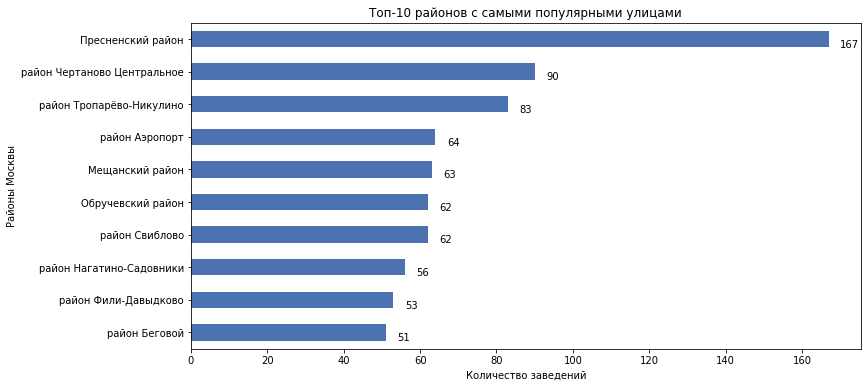

In [32]:
data_with_district_top = data_with_district.groupby('district').agg(count_object=('id','count')).sort_values(by='count_object', ascending=False).head(10)

ax = data_with_district_top.plot(kind='barh', figsize=(12,6), legend=None)
ax.invert_yaxis()
ax.set_title('Топ-10 районов с самыми популярными улицами') 
ax.set_ylabel('Районы Москвы')
ax.set_xlabel("Количество заведений")
for i, v in enumerate(data_with_district_top['count_object']):
    ax.text(v + 3, i + .25, str(v))

Самый популярный с большим отрывом район для заведений: Пресненский, он почти в 2 раза популярней района, находящегося на втором месте: Чертаново Центральное.

### Улицы с одним объектом общественного питания, районы их расположения.

In [33]:
one_object = data.groupby('street').agg(count_object=('id','count')).query('count_object == 1').reset_index()
one_object

,street,count_object
0,1-й Балтийский переулок,1
1,1-й Басманный переулок,1
2,1-й Ботанический проезд,1
3,1-й Вешняковский проезд,1
4,1-й Голутвинский переулок,1
...,...,...
565,улица Шеногина,1
566,улица Шумилова,1
567,улица Шумкина,1
568,улица Щорса,1


In [34]:
# для удобства вывожу всю информацию по улицам с одним объектом общественного питания
street_one_object = one_object['street'].tolist()
data_one_object = data.query('street in @street_one_object')
data_one_object

,id,object_name,chain,object_type,address,number,street
19,153644,американская лаборатория десертов,нет,кафе,"город Москва, Филипповский переулок, дом 15/5",20,Филипповский переулок
61,21214,столовая,нет,столовая,"город Москва, Бабаевская улица, дом 3",90,Бабаевская улица
69,22139,хуанхэ,нет,ресторан,"город Москва, 1-й Балтийский переулок, дом 3/25",60,1-й Балтийский переулок
81,25833,азербайджан,нет,ресторан,"город Москва, улица Демьяна Бедного, дом 4",180,улица Демьяна Бедного
131,150881,вгик,нет,столовая,"город Москва, Будайская улица, дом 3",45,Будайская улица
...,...,...,...,...,...,...,...
14808,213635,кафе,нет,кафе,"город Москва, поселение Сосенское, деревня Сосенки, Ясеневая улица, дом 3",46,"поселение Сосенское, деревня Сосенки, Ясеневая улица"
14810,206875,столовая,нет,столовая,"город Москва, поселение Первомайское, деревня Поповка, Дорожная улица, дом 12, строение 1",28,"поселение Первомайское, деревня Поповка, Дорожная улица"
14974,213930,горячий хлеб,нет,предприятие быстрого обслуживания,"город Москва, поселение Десеновское, улица Дмитрия Рябинкина, дом 13",0,"поселение Десеновское, улица Дмитрия Рябинкина"
15017,205588,кофейня,нет,кафетерий,"город Москва, поселение Щаповское, улица Евгения Родионова, владение 1",16,"поселение Щаповское, улица Евгения Родионова"


In [35]:
# применяю функцию, записываю район и сохраняю все во внешний файл
# код закомментирую, чтобы не выполнялся каждый раз заново

# data_one_object['district'] = data_one_object['address'].apply(req_district)
# data_one_object.to_csv(path_or_buf='./data_one_object.csv')

In [36]:
# вывожу записанный файл с районами
spreadsheet_id_2 = '' # убрала ссылку на файл
file_name_2 = 'https://docs.google.com/spreadsheets/d/{}/export?format=csv'.format(spreadsheet_id_2)
r = requests.get(file_name_2)
data_one_object_with_district = pd.read_csv(BytesIO(r.content), index_col=0)
data_one_object_with_district

,id,object_name,chain,object_type,address,number,street,district
19,153644,американская лаборатория десертов,нет,кафе,"город Москва, Филипповский переулок, дом 15/5",20,Филипповский переулок,район Арбат
61,21214,столовая,нет,столовая,"город Москва, Бабаевская улица, дом 3",90,Бабаевская улица,район Сокольники
69,22139,хуанхэ,нет,ресторан,"город Москва, 1-й Балтийский переулок, дом 3/25",60,1-й Балтийский переулок,район Аэропорт
81,25833,азербайджан,нет,ресторан,"город Москва, улица Демьяна Бедного, дом 4",180,улица Демьяна Бедного,район Хорошёво-Мнёвники
131,150881,вгик,нет,столовая,"город Москва, Будайская улица, дом 3",45,Будайская улица,район Ростокино
...,...,...,...,...,...,...,...,...
14808,213635,кафе,нет,кафе,"город Москва, поселение Сосенское, деревня Сосенки, Ясеневая улица, дом 3",46,"поселение Сосенское, деревня Сосенки, Ясеневая улица",Error
14810,206875,столовая,нет,столовая,"город Москва, поселение Первомайское, деревня Поповка, Дорожная улица, дом 12, строение 1",28,"поселение Первомайское, деревня Поповка, Дорожная улица",Error
14974,213930,горячий хлеб,нет,предприятие быстрого обслуживания,"город Москва, поселение Десеновское, улица Дмитрия Рябинкина, дом 13",0,"поселение Десеновское, улица Дмитрия Рябинкина",Error
15017,205588,кофейня,нет,кафетерий,"город Москва, поселение Щаповское, улица Евгения Родионова, владение 1",16,"поселение Щаповское, улица Евгения Родионова",Error


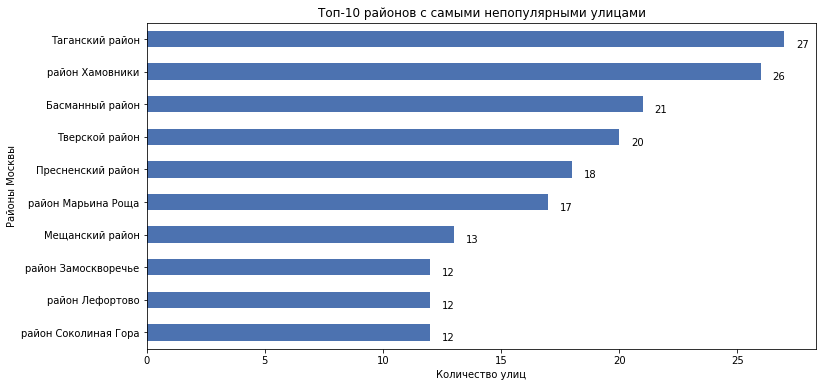

In [37]:
data_one_object_with_district_top = data_one_object_with_district.groupby('district').agg(count_object=('id','count')).sort_values(by='count_object', ascending=False).reset_index().query('district != "Error"').head(10)

ax = data_one_object_with_district_top.plot(kind='barh', x='district', figsize=(12,6), legend=None)
ax.invert_yaxis()
ax.set_title('Топ-10 районов с самыми непопулярными улицами') 
ax.set_ylabel('Районы Москвы')
ax.set_xlabel("Количество улиц")
for i, v in enumerate(data_one_object_with_district_top['count_object']):
    ax.text(v + .5, i + .25, str(v))

Самые непопулярные районы: Таганский, Хамовники и Басманский.

### Распределение количества посадочных мест для улиц с большим количеством объектов общественного питания

In [38]:
data_with_district_mean_number = data_with_district.groupby('street').agg(mean_number=('number','mean')).sort_values(by='mean_number', ascending=False)
data_with_district_mean_number['mean_number'] = data_with_district_mean_number['mean_number'].astype('int')
data_with_district_mean_number

,mean_number
street,
Кутузовский проспект,85
проспект Вернадского,68
Ленинский проспект,63
проспект Мира,62
Кировоградская улица,59
Каширское шоссе,55
Варшавское шоссе,52
Ленинградский проспект,52
Профсоюзная улица,46


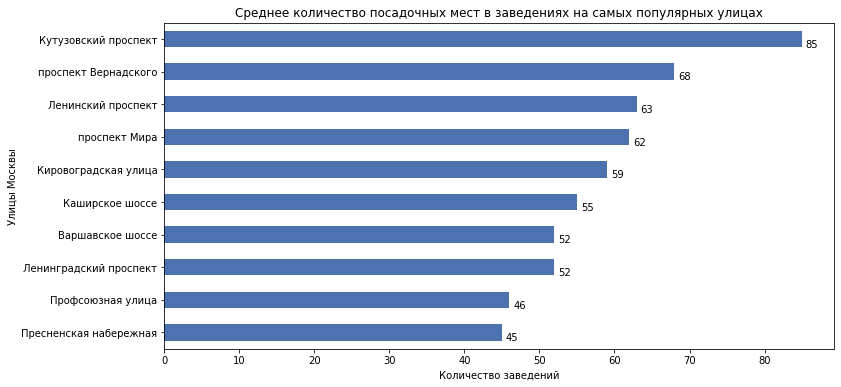

In [39]:
ax = data_with_district_mean_number.plot(kind='barh', figsize=(12,6), legend=None)
ax.invert_yaxis()
ax.set_title('Среднее количество посадочных мест в заведениях на самых популярных улицах') 
ax.set_ylabel('Улицы Москвы')
ax.set_xlabel("Количество заведений")
for i, v in enumerate(data_with_district_mean_number['mean_number']):
    ax.text(v + .5, i + .25, str(v))

В заведениях, расположенных на улицах с самым большим количеством объектов общественного питания в среднем от 45 до 85 посадочных мест.

## Вывод

Сделайте общий вывод и дайте рекомендации о виде заведения, количестве посадочных мест, а также районе расположения. Прокомментируйте возможность развития сети

Общий вывод:
1. Больше всего заведений вида "кафе" - 6071 шт - и они составляют 39,7% от общего числа заведений. Топ-3 объектов по количеству заведений: кафе, столовые, рестораны
2. Количество несетевых заведений в 4 раза больше, чем сетевых.
3. Больше всего сетевых заведений вида "кафе" - 1396 шт - и они составляют 47,1% от общего числа заведений. Топ-3 объектов по количеству сетевых заведений: кафе, предприятия быстрого обслуживания, рестораны; в сумме дают 92% об общего числа заведений.
4. Для сетевых объектов питания характерно большое количество заведений с небольшим количеством посадочных мест - до 200.
5. Топ-3 по количеству посадочных мест: столовые, рестораны, буфеты.
6. Самые популярные улицы: проспект Мира, Профсоюзная улица, Ленинградский проспект. Самый популярный с большим отрывом район для заведений: Пресненский, он почти в 2 раза популярней районов, находящихся на втором и третьем месте: Чертаново Центральное, Тропарёво-Никулино.
7. Самые непопулярные районы: Таганский, Хамовники и Басманский.
8. В заведениях, расположенных на улицах с самым большим количеством объектов общественного питания в среднем от 45 до 85 посадочных мест.

Рекомендации:
1. Вид объекта общественного питания - кафе.
2. С количеством посадочных мест от 45 до 85.
3. Район расположения - проспект Мира, Пресненский район.
4. Возможность развития сети есть, можно открыть такие же по виду и количеству посадочных мест заведения в районе Чертаново Центральное и Тропарёво-Никулино.

## Презентация

Презентация: https://disk.yandex.ru/i/60OEip1cGymXDg